In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet101, ResNet101_Weights
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # 如果在 Jupyter/Kaggle 環境，tqdm 比較保險

import multiprocessing
print(multiprocessing.cpu_count())

print(torch.version.cuda)          # 應該顯示你當前 PyTorch 內建的 CUDA 版本
print(torch.backends.cudnn.version())  # 顯示 cuDNN 版本
print(torch.cuda.is_available())   # 是否為 True

4
12.1
90100
True


In [2]:
class CustomFolderDataset(Dataset):
    """
    假設資料夾結構:
    data/train/0, data/train/1, ... data/train/99
    data/val/0,   data/val/1,   ... data/val/99
    """
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        subfolders = os.listdir(root_dir)
        # 排序，避免 '10' 排在 '2' 前面
        subfolders = sorted(subfolders, key=lambda x: int(x))
        for folder_name in subfolders:
            folder_path = os.path.join(root_dir, folder_name)
            if not os.path.isdir(folder_path):
                continue
            label = int(folder_name)
            for fname in os.listdir(folder_path):
                img_path = os.path.join(folder_path, fname)
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def mixup_data(x, y, alpha=1.0):
    """
    mixup: https://arxiv.org/abs/1710.09412
    x: images batch (Tensor)
    y: labels batch (Tensor of class index)
    alpha: mixup hyperparam (典型值 0.2 ~ 1.0)
    回傳: (mixed_x, y_a, y_b, lam)
    """
    if alpha <= 0:
        return x, y, y, 1.0

    batch_size = x.size(0)
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)



# 驗證用函式
def evaluate(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


class TestDataset(Dataset):
    """
    讀取 data/test/ 下所有圖片(不分子資料夾)，無標籤。
    傳回 (image, filename)，以便推論後輸出檔名對應的結果。
    """
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        # 收集所有檔案(僅圖片，副檔名可再自行篩)
        self.files = [f for f in os.listdir(root_dir)
                      if os.path.isfile(os.path.join(root_dir, f))]
        # 排序一下，以確保輸出順序固定
        self.files.sort()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.root_dir, fname)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, fname


In [3]:
# 假設我們將 data 放在 /kaggle/input/your_dataset_name/data

train_dir = "/kaggle/input/vrdlhw1data/data/train"
val_dir   = "/kaggle/input/vrdlhw1data/data/val"
num_classes  = 100
batch_size   = 32
num_epochs   = 50
learning_rate = 0.001
alpha_mixup = 0.2   # 如果不想用 mixup, 設 0.0
dropout_p   = 0.3   # MLP 中的 dropout 比例


In [4]:
# 資料增強
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((224,224), scale=(0.8,1.0), ratio=(1.0,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
# 建立Dataset & DataLoader
train_dataset = CustomFolderDataset(train_dir, transform=train_transform)
val_dataset   = CustomFolderDataset(val_dir,   transform=val_transform)

train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=3)
val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

Using device: cuda
Train samples: 20724
Val samples: 300


In [6]:
class MyCustomResNet(nn.Module):
    """
    在 ResNet101 上進行以下操作：
    1) 使用 ImageNet 預訓練權重
    2) 移除原本的 fc (nn.Linear(2048, 1000))
    3) 換成自訂 MLP (多層線性層 + Dropout)
    """
    def __init__(self, num_classes=100, dropout_p=0.3):
        super(MyCustomResNet, self).__init__()
        # 1) 載入預訓練的 ResNet101
        self.base = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)

        # 2) 取出 in_features
        in_features = self.base.fc.in_features  # 2048
        # 移除原本 fc
        self.base.fc = nn.Identity()

        # 3) 自訂兩層 MLP
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.base(x)           # [batch_size, 2048]
        out = self.classifier(features)   # [batch_size, num_classes]
        return out

## train

In [7]:
model = MyCustomResNet(num_classes=num_classes, dropout_p=dropout_p)


# **檢測是否有多顆 GPU**
num_gpus = torch.cuda.device_count()
print("Number of GPUs:", num_gpus)
if num_gpus > 1:
    print("Using DataParallel on", num_gpus, "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

# 參數量
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

# D. 定義 Loss (Label Smoothing) & Optimizer (Weight Decay)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

train_losses = []
val_losses   = []
val_accs     = []

# E. 訓練
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        # MixUp
        if alpha_mixup > 0:
            imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, alpha_mixup)
        else:
            labels_a, labels_b = labels, labels
            lam = 1.0

        optimizer.zero_grad()
        outputs = model(imgs)

        if alpha_mixup > 0:
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    val_loss, val_acc = evaluate(model, val_loader, device, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 儲存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        if num_gpus > 1:
            torch.save(model.module.state_dict(), "best_model.pt")
        else:
            torch.save(model.state_dict(), "best_model.pt")
        print(f"  >> Best model saved. (Val Acc: {best_acc:.4f})")

print("Training finished. Best Val Acc =", best_acc)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 178MB/s]


Number of GPUs: 2
Using DataParallel on 2 GPUs!
Total parameters: 43600548


Epoch 1/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 1/50] Train Loss: 3.8875, Val Loss: 3.6010, Val Acc: 0.2700
  >> Best model saved. (Val Acc: 0.2700)


Epoch 2/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 2/50] Train Loss: 2.8754, Val Loss: 2.8305, Val Acc: 0.3867
  >> Best model saved. (Val Acc: 0.3867)


Epoch 3/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 3/50] Train Loss: 2.4216, Val Loss: 2.3717, Val Acc: 0.5133
  >> Best model saved. (Val Acc: 0.5133)


Epoch 4/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 4/50] Train Loss: 2.2346, Val Loss: 2.1469, Val Acc: 0.5533
  >> Best model saved. (Val Acc: 0.5533)


Epoch 5/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 5/50] Train Loss: 2.0361, Val Loss: 1.9644, Val Acc: 0.6333
  >> Best model saved. (Val Acc: 0.6333)


Epoch 6/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 6/50] Train Loss: 1.9254, Val Loss: 1.8987, Val Acc: 0.6533
  >> Best model saved. (Val Acc: 0.6533)


Epoch 7/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 7/50] Train Loss: 1.8723, Val Loss: 1.8416, Val Acc: 0.6467


Epoch 8/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 8/50] Train Loss: 1.7747, Val Loss: 1.7384, Val Acc: 0.7033
  >> Best model saved. (Val Acc: 0.7033)


Epoch 9/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 9/50] Train Loss: 1.7871, Val Loss: 1.7329, Val Acc: 0.7167
  >> Best model saved. (Val Acc: 0.7167)


Epoch 10/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 10/50] Train Loss: 1.7384, Val Loss: 1.6723, Val Acc: 0.7300
  >> Best model saved. (Val Acc: 0.7300)


Epoch 11/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 11/50] Train Loss: 1.6647, Val Loss: 1.6687, Val Acc: 0.7300


Epoch 12/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 12/50] Train Loss: 1.6650, Val Loss: 1.5770, Val Acc: 0.7667
  >> Best model saved. (Val Acc: 0.7667)


Epoch 13/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 13/50] Train Loss: 1.6056, Val Loss: 1.6057, Val Acc: 0.7433


Epoch 14/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 14/50] Train Loss: 1.6360, Val Loss: 1.6102, Val Acc: 0.7467


Epoch 15/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 15/50] Train Loss: 1.5648, Val Loss: 1.6445, Val Acc: 0.7267


Epoch 16/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 16/50] Train Loss: 1.5430, Val Loss: 1.6103, Val Acc: 0.7500


Epoch 17/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 17/50] Train Loss: 1.5650, Val Loss: 1.5273, Val Acc: 0.7667


Epoch 18/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 18/50] Train Loss: 1.5462, Val Loss: 1.5859, Val Acc: 0.7567


Epoch 19/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 19/50] Train Loss: 1.4142, Val Loss: 1.6080, Val Acc: 0.7467


Epoch 20/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 20/50] Train Loss: 1.5243, Val Loss: 1.5784, Val Acc: 0.7600


Epoch 21/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 21/50] Train Loss: 1.5088, Val Loss: 1.6030, Val Acc: 0.7633


Epoch 22/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 22/50] Train Loss: 1.5089, Val Loss: 1.6015, Val Acc: 0.7667


Epoch 23/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 23/50] Train Loss: 1.4581, Val Loss: 1.5717, Val Acc: 0.7833
  >> Best model saved. (Val Acc: 0.7833)


Epoch 24/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 24/50] Train Loss: 1.4316, Val Loss: 1.6097, Val Acc: 0.7567


Epoch 25/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 25/50] Train Loss: 1.4273, Val Loss: 1.5621, Val Acc: 0.7633


Epoch 26/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 26/50] Train Loss: 1.5253, Val Loss: 1.5453, Val Acc: 0.7900
  >> Best model saved. (Val Acc: 0.7900)


Epoch 27/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 27/50] Train Loss: 1.3945, Val Loss: 1.5901, Val Acc: 0.7633


Epoch 28/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 28/50] Train Loss: 1.4340, Val Loss: 1.5220, Val Acc: 0.7700


Epoch 29/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 29/50] Train Loss: 1.4136, Val Loss: 1.5288, Val Acc: 0.7667


Epoch 30/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 30/50] Train Loss: 1.3591, Val Loss: 1.5933, Val Acc: 0.7467


Epoch 31/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 31/50] Train Loss: 1.4272, Val Loss: 1.4939, Val Acc: 0.7867


Epoch 32/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 32/50] Train Loss: 1.4002, Val Loss: 1.5046, Val Acc: 0.7933
  >> Best model saved. (Val Acc: 0.7933)


Epoch 33/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 33/50] Train Loss: 1.3509, Val Loss: 1.5100, Val Acc: 0.7833


Epoch 34/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 34/50] Train Loss: 1.4292, Val Loss: 1.4672, Val Acc: 0.8000
  >> Best model saved. (Val Acc: 0.8000)


Epoch 35/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 35/50] Train Loss: 1.4513, Val Loss: 1.5005, Val Acc: 0.7833


Epoch 36/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 36/50] Train Loss: 1.3873, Val Loss: 1.5965, Val Acc: 0.7500


Epoch 37/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 37/50] Train Loss: 1.4143, Val Loss: 1.5324, Val Acc: 0.7800


Epoch 38/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 38/50] Train Loss: 1.4108, Val Loss: 1.5334, Val Acc: 0.7767


Epoch 39/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 39/50] Train Loss: 1.3530, Val Loss: 1.5888, Val Acc: 0.7800


Epoch 40/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 40/50] Train Loss: 1.3703, Val Loss: 1.5068, Val Acc: 0.7933


Epoch 41/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 41/50] Train Loss: 1.4220, Val Loss: 1.5354, Val Acc: 0.7733


Epoch 42/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 42/50] Train Loss: 1.3697, Val Loss: 1.5253, Val Acc: 0.7733


Epoch 43/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 43/50] Train Loss: 1.3224, Val Loss: 1.5102, Val Acc: 0.7967


Epoch 44/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 44/50] Train Loss: 1.3808, Val Loss: 1.5291, Val Acc: 0.7867


Epoch 45/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 45/50] Train Loss: 1.3735, Val Loss: 1.5215, Val Acc: 0.7867


Epoch 46/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 46/50] Train Loss: 1.4369, Val Loss: 1.5006, Val Acc: 0.8067
  >> Best model saved. (Val Acc: 0.8067)


Epoch 47/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 47/50] Train Loss: 1.3396, Val Loss: 1.5234, Val Acc: 0.7900


Epoch 48/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 48/50] Train Loss: 1.3637, Val Loss: 1.4695, Val Acc: 0.8100
  >> Best model saved. (Val Acc: 0.8100)


Epoch 49/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 49/50] Train Loss: 1.3589, Val Loss: 1.5094, Val Acc: 0.8100


Epoch 50/50:   0%|          | 0/648 [00:00<?, ?it/s]

[Epoch 50/50] Train Loss: 1.3639, Val Loss: 1.5660, Val Acc: 0.7633
Training finished. Best Val Acc = 0.81


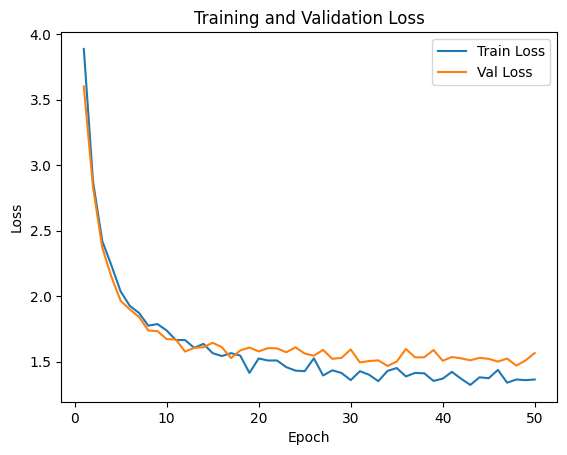

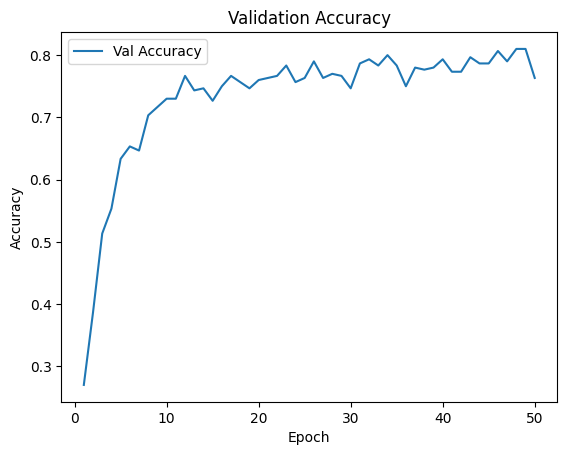

In [8]:
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("trainval_loss.png")
plt.show()

# (B) Val Accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.savefig("val_acc.png")
plt.show()


## test

In [9]:
test_dir = "/kaggle/input/vrdlhw1data/data/test"
model_path = "/kaggle/working/best_model.pt"  # 上面訓練儲存的檔案
num_classes = 100

# 依照訓練同樣的 Normalize
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 建立 TestDataset
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 重建模型並載入權重
model = MyCustomResNet(num_classes=100).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))  # <-- 請務必加上
model.eval()

results = []
with torch.no_grad():
    for images, fnames in tqdm(test_loader, desc="Inference"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        
        for fname, label_id in zip(fnames, preds):
            results.append((fname, label_id))

# 輸出 CSV 檔到 /kaggle/working
output_path = "/kaggle/working/prediction.csv"
with open(output_path, "w") as f:
    f.write("image_name,pred_label\n")
    for fname, label_id in results:
        filename_no_ext = os.path.splitext(fname)[0]
        f.write(f"{filename_no_ext},{label_id}\n")

print("Inference done. Results saved to", output_path)


Using device: cuda


<ipython-input-9-c2fc227a70c4>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # <-- 請務必加上


Inference:   0%|          | 0/74 [00:00<?, ?it/s]

Inference done. Results saved to /kaggle/working/prediction.csv
